In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] a= 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False


# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

In [2]:
df = pd.read_csv('data/merged_data_brand_dropna.csv')

In [3]:
# datetime 컬럼 변환
df['event_time_moscow'] = pd.to_datetime(df['event_time_moscow'])

## cart 행동 기반 코호트 분석

- **장바구니 행동 기반**
    - 조건: **장바구니(cart)** 에 3회 이상 담은 사용자
    - 코호트 기준: `user_id`가 장바구니 이벤트를 3회 이상 발생시킨 첫 시점
    - 분석: 이후 n일 내 구매율 변화 추적

In [ ]:
import pandas as pd

# 1. event_time 처리
df['event_time'] = pd.to_datetime(df['event_time_moscow'], errors='coerce')
df = df.sort_values(by=['user_id', 'event_time'])  # 시간 순 정렬

In [ ]:
# 2. cart 이벤트만 필터링
cart_df = df[df['event_type'] == 'cart'].copy()

# 3. 사용자별 cart 이벤트 누적 카운트
cart_df['cart_cumcount'] = cart_df.groupby('user_id').cumcount() + 1

# 4. 3번째 cart 이벤트만 추출
cart_3rd_df = cart_df[cart_df['cart_cumcount'] == 3].copy()

# 5. user_id별로 cart 3회차 시점 확인
user_cart3_time = cart_3rd_df[['user_id', 'event_time']].rename(columns={'event_time': 'cohort_time'})

In [ ]:
# 6. 전체 df에 cohort_time 병합
df = df.merge(user_cart3_time, on='user_id', how='inner')  # 3회 이상 cart 한 유저만

# 7. 기준일 이후 이벤트만 필터링
df = df[df['event_time'] >= df['cohort_time']].copy()

# 8. 기준 시점 대비 N일 경과 계산
df['days_since_cart3'] = (df['event_time'] - df['cohort_time']).dt.days

In [ ]:
# 9. 중복 제거: 유저가 특정 일에 구매했는지 여부만 체크
purchase_log = df[df['event_type'] == 'purchase'][['user_id', 'days_since_cart3']].drop_duplicates()

# 10. 전체 유저 수 (코호트 기준 유저)
total_users = user_cart3_time['user_id'].nunique()

# 11. 일자별 구매 유저 수
daily_purchases = (
    purchase_log.groupby('days_since_cart3')['user_id'].nunique()
    .reindex(range(0, 15), fill_value=0)  # 최대 15일까지 보고 싶다면
)

# 12. 구매율 계산
purchase_rate = daily_purchases / total_users * 100
purchase_rate.name = 'purchase_rate'

In [ ]:
import matplotlib.pyplot as plt

# 13. 시각화
plt.figure(figsize=(8, 4))
purchase_rate.plot(kind='bar', color='skyblue')
plt.title('장바구니 3회차 이후 N일차 구매율')
plt.xlabel('N일차')
plt.ylabel('구매율 (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 14. CSV 저장 (선택)
purchase_rate.reset_index().rename(columns={'index': 'days_since_cart3'}).to_csv('cohort_cart3_purchase_rate.csv', index=False)

- 유의미하게 높거나, 특출나지 않음

- 장바구니 3회까지 걸리는 시간을 기준으로 그룹 분할
- 1일 이내, 3일 이내, 7일 이내, 7일 초과

In [ ]:
import pandas as pd

# cart 이벤트만 필터링
cart_df = df[df['event_type'] == 'cart'].copy()
cart_df['event_time'] = pd.to_datetime(cart_df['event_time_moscow'], errors='coerce')
cart_df = cart_df.sort_values(by=['user_id', 'event_time'])

# 각 user_id 내에서 cart 이벤트 순서 부여
cart_df['cart_order'] = cart_df.groupby('user_id').cumcount() + 1

# 1회차와 3회차 추출
cart1 = cart_df[cart_df['cart_order'] == 1][['user_id', 'event_time']].rename(columns={'event_time': 'cart1_time'})
cart3 = cart_df[cart_df['cart_order'] == 3][['user_id', 'event_time']].rename(columns={'event_time': 'cart3_time'})

# 병합 후 시간 차 계산
cart_duration = pd.merge(cart1, cart3, on='user_id')
cart_duration['days_to_3rd_cart'] = (cart_duration['cart3_time'] - cart_duration['cart1_time']).dt.days

In [ ]:
# 코호트 그룹 분류 (예시: 빠름/중간/느림)
def categorize_days(days):
    if days <= 1:
        return '1일 이내'
    elif days <= 3:
        return '3일 이내'
    elif days <= 7:
        return '7일 이내'
    else:
        return '7일 초과'

cart_duration['cohort_group'] = cart_duration['days_to_3rd_cart'].apply(categorize_days)

In [ ]:
cart_duration['cohort_group'].value_counts()

In [ ]:
# cart3_time 기준 이후 행동만 분석
df['event_time'] = pd.to_datetime(df['event_time_moscow'], errors='coerce')
df = df.merge(cart_duration[['user_id', 'cart3_time', 'cohort_group']], on='user_id', how='inner')
df = df[df['event_time'] >= df['cart3_time']].copy()
df['days_since_cart3'] = (df['event_time'] - df['cart3_time']).dt.days

In [ ]:
# 구매 로그만 추출
purchase_log = df[df['event_type'] == 'purchase'][['user_id', 'days_since_cart3', 'cohort_group']].drop_duplicates()

# 전체 유저 수 (코호트별)
cohort_user_counts = cart_duration.groupby('cohort_group')['user_id'].nunique()

# 일자별 구매자 수
daily_purchase = (
    purchase_log.groupby(['cohort_group', 'days_since_cart3'])['user_id'].nunique()
    .unstack(fill_value=0)
)

# 비율로 전환
cohort_purchase_rate = daily_purchase.divide(cohort_user_counts, axis=0) * 100

In [ ]:
import matplotlib.pyplot as plt

# 0일차 제거
cohort_purchase_rate = cohort_purchase_rate.drop(columns=0, errors='ignore')

plt.figure(figsize=(10, 6))
for cohort in cohort_purchase_rate.index:
    plt.plot(cohort_purchase_rate.columns, cohort_purchase_rate.loc[cohort], label=cohort)

plt.title('장바구니 3회까지 걸린 시간별 코호트 구매율')
plt.xlabel('N일차')
plt.ylabel('구매율 (%)')
plt.legend(title='코호트 그룹')
plt.grid(True)
plt.tight_layout()
plt.show()

- 장바구니 3회를 며칠에 걸쳐 달성했는지는 큰 유의미성을 보이지는 않는다.
- 3일 이내, 7일 이내 그룹이 비교적 높고, 1일 이내가 비교적 낮은 듯

### 가설 검정

- 귀무가설(H₀): cart에 3회 이상 담은 사용자와 그렇지 않은 사용자 간 구매율 차이가 없다.
- 대립가설(H₁): cart에 3회 이상 담은 사용자가 이후 구매율이 더 높다.

In [9]:
import pandas as pd
from scipy.stats import chi2_contingency

# 1. event_time 형 변환 및 정렬
df['event_time'] = pd.to_datetime(df['event_time_moscow'])
df = df.sort_values(['user_id', 'event_time'])

# 2. cart 이벤트 필터링 후 순서 부여
cart_df = df[df['event_type'] == 'cart'].copy()
cart_df['cart_order'] = cart_df.groupby('user_id').cumcount() + 1

# 3. 사용자별 3번째 cart 시점 추출
third_cart_time = cart_df[cart_df['cart_order'] == 3][['user_id', 'event_time']]
third_cart_time.columns = ['user_id', 'cart3_time']  # 병합을 위한 컬럼명 변경

# 4. 원본 df에 cart3_time 병합
df = df.merge(third_cart_time, on='user_id', how='left')

# 5. cart3 이후 이벤트 여부 플래그 생성
df['after_cart3'] = df['event_time'] > df['cart3_time']

# 6. cart 3회 이상 사용자 리스트
users_with_cart3 = third_cart_time['user_id'].unique()

# 7. cart 3회 미만 사용자 리스트
users_without_cart3 = df[~df['user_id'].isin(users_with_cart3)]['user_id'].unique()

# 8. cart3 이후에 구매한 사용자 추출
purchase_after_cart3 = df[
    (df['event_type'] == 'purchase') &
    (df['after_cart3'] == True)
]['user_id'].unique()

# 9. 그룹별 구매 여부 계산
a_purchase = sum(pd.Series(users_with_cart3).isin(purchase_after_cart3))
a_non = len(users_with_cart3) - a_purchase

b_purchase = sum(pd.Series(users_without_cart3).isin(purchase_after_cart3))
b_non = len(users_without_cart3) - b_purchase

# 10. 교차표 생성 및 카이제곱 검정
contingency = [[a_purchase, a_non], [b_purchase, b_non]]
chi2, p, _, _ = chi2_contingency(contingency)

# 11. 구매율 계산
a_rate = a_purchase / (a_purchase + a_non) if (a_purchase + a_non) > 0 else 0
b_rate = b_purchase / (b_purchase + b_non) if (b_purchase + b_non) > 0 else 0

# 12. 결과 출력
print("✅ 교차표:", contingency)
print(f"✅ p-value: {p:.5f}")
print(f"✅ cart 3회 이상 사용자 구매율: {a_rate:.2%}")
print(f"✅ cart 3회 미만 사용자 구매율: {b_rate:.2%}")

✅ 교차표: [[80257, 131558], [0, 991800]]
✅ p-value: 0.00000
✅ cart 3회 이상 사용자 구매율: 37.89%
✅ cart 3회 미만 사용자 구매율: 0.00%


- cart에 3회 이상 담은 이들의 차후 구매율이 높다.

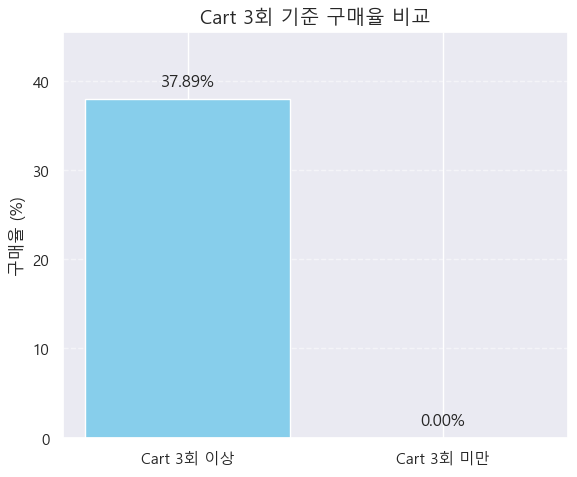

In [10]:
import matplotlib.pyplot as plt

# 1. 데이터 구성
labels = ['Cart 3회 이상', 'Cart 3회 미만']
purchase_rates = [a_rate * 100, b_rate * 100]  # 퍼센트로 변환

# 2. 시각화
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, purchase_rates, color=['skyblue', 'lightcoral'])

# 3. 값 라벨 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=12)

# 4. 제목 및 라벨
plt.title('Cart 3회 기준 구매율 비교', fontsize=14)
plt.ylabel('구매율 (%)')
plt.ylim(0, max(purchase_rates) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- cart 1회 이상

In [6]:
import pandas as pd
from scipy.stats import chi2_contingency

# 1. event_time 형 변환 및 정렬
df['event_time'] = pd.to_datetime(df['event_time_moscow'])
df = df.sort_values(['user_id', 'event_time'])

# 2. cart 이벤트 필터링 후 순서 부여
cart_df = df[df['event_type'] == 'cart'].copy()
cart_df['cart_order'] = cart_df.groupby('user_id').cumcount() + 1

# 3. 사용자별 1번째 cart 시점 추출
first_cart_time = cart_df[cart_df['cart_order'] == 1][['user_id', 'event_time']]
first_cart_time.columns = ['user_id', 'cart1_time']

# 4. 원본 df에 cart1_time 병합
df = df.merge(first_cart_time, on='user_id', how='left')

# 5. cart1 이후 이벤트 여부 플래그 생성
df['after_cart1'] = df['event_time'] > df['cart1_time']

# 6. cart 1회 이상 사용자 리스트
users_with_cart1 = first_cart_time['user_id'].unique()

# 7. cart 1회 미만 사용자 리스트
users_without_cart1 = df[~df['user_id'].isin(users_with_cart1)]['user_id'].unique()

# 8. cart1 이후에 구매한 사용자 추출
purchase_after_cart1 = df[
    (df['event_type'] == 'purchase') &
    (df['after_cart1'] == True)
]['user_id'].unique()

# 9. 그룹별 구매 여부 계산
a_purchase = sum(pd.Series(users_with_cart1).isin(purchase_after_cart1))
a_non = len(users_with_cart1) - a_purchase

b_purchase = sum(pd.Series(users_without_cart1).isin(purchase_after_cart1))
b_non = len(users_without_cart1) - b_purchase

# 10. 교차표 및 카이제곱 검정
contingency = [[a_purchase, a_non], [b_purchase, b_non]]
chi2, p, _, _ = chi2_contingency(contingency)

# 11. 구매율 계산
a_rate = a_purchase / (a_purchase + a_non) if (a_purchase + a_non) > 0 else 0
b_rate = b_purchase / (b_purchase + b_non) if (b_purchase + b_non) > 0 else 0

# 12. 결과 출력
print("✅ 교차표:", contingency)
print(f"✅ p-value: {p:.5f}")
print(f"✅ cart 1회 이상 사용자 구매율: {a_rate:.2%}")
print(f"✅ cart 1회 미만 사용자 구매율: {b_rate:.2%}")

✅ 교차표: [[96828, 219125], [0, 887662]]
✅ p-value: 0.00000
✅ cart 1회 이상 사용자 구매율: 30.65%
✅ cart 1회 미만 사용자 구매율: 0.00%


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19400\2996166584.py:22: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\Administrator\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


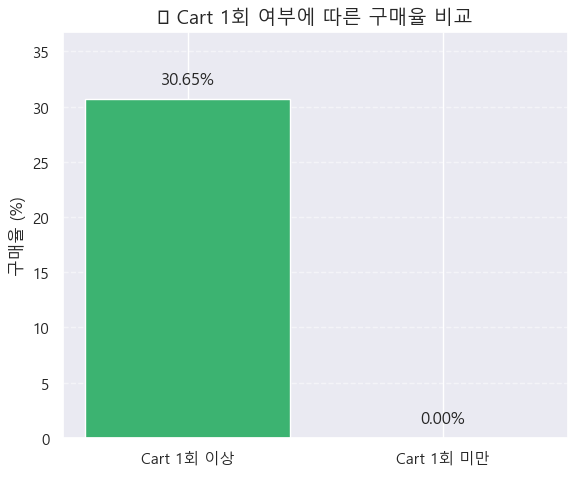

In [7]:
import matplotlib.pyplot as plt

# 1. 시각화용 데이터
labels = ['Cart 1회 이상', 'Cart 1회 미만']
purchase_rates = [a_rate * 100, b_rate * 100]  # 퍼센트로 변환

# 2. 막대그래프
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, purchase_rates, color=['mediumseagreen', 'lightgray'])

# 3. 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=12)

# 4. 제목 및 서식
plt.title('✅ Cart 1회 여부에 따른 구매율 비교', fontsize=14)
plt.ylabel('구매율 (%)')
plt.ylim(0, max(purchase_rates) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [8]:
# 1. cart 이벤트가 발생한 사용자 목록
users_with_cart = df[df['event_type'] == 'cart']['user_id'].unique()

# 2. 전체 사용자 목록
all_users = df['user_id'].unique()

# 3. cart가 한 번도 없는 사용자
users_without_cart = set(all_users) - set(users_with_cart)

# 4. 이 사용자들의 전체 이벤트 로그를 하나의 df로 추출
df_no_cart = df[df['user_id'].isin(users_without_cart)].copy()

# 결과 확인
print(f"✅ cart 이벤트가 한 번도 없는 사용자 수: {len(users_without_cart)}")
print(f"✅ df_no_cart 행 개수: {len(df_no_cart)}")

✅ cart 이벤트가 한 번도 없는 사용자 수: 887662
✅ df_no_cart 행 개수: 1983885


In [12]:
# 1. df_no_cart에서 구매 이벤트 필터링
no_cart_purchase = df_no_cart[df_no_cart['event_type'] == 'purchase']

# 2. 고유 사용자 수 확인
unique_buyers = no_cart_purchase['user_id'].nunique()

# 3. 결과 출력
print(f"✅ cart 없이 구매한 사용자 수: {unique_buyers}")
print(f"✅ 해당 구매 이벤트 총 개수: {len(no_cart_purchase)}")

✅ cart 없이 구매한 사용자 수: 1351
✅ 해당 구매 이벤트 총 개수: 7258


- 결론
    - cart에 3회 이상 담은 이들의 차후 구매율이 압도적으로 높다.
    - cart에 1회라도 담은 이들의 차후 구매율이 압도적으로 높다
    (둘다 n회 미만 그룹의 구매율이 0.00%)

## H28_특정 브랜드 상품을 5번 이상 조회(view) 한 사용자 코호트

- 조건: 특정 브랜드 상품을 **5번 이상 조회(view)** 한 사용자
- 코호트 기준: 특정 브랜드 집중 행동의 시작 시점
- 분석: 뷰 수가 구매로 이어지는 전환율 비교

- 귀무가설(H0): 브랜드 기준으로 view를 5회 이상 했더라도 구매 전환율에 차이가 없다.
- 대립가설(H1): 특정 브랜드를 view 5회 이상 한 사용자가 그렇지 않은 사용자보다 더 많이 구매한다.

- 기준: 브랜드별로 view ≥ 5회인 사용자 → 집중 관심 사용자
- 비교 대상: 같은 브랜드를 view < 5회인 사용자
- 두 그룹의 구매 전환율 비교 → 카이제곱 검정 또는 비율 검정

In [14]:
import pandas as pd
from scipy.stats import chi2_contingency

# 브랜드-사용자별 view 수 계산
view_counts = df[df['event_type'] == 'view'].groupby(['brand', 'user_id']).size().reset_index(name='view_count')

# 구매 여부 플래그 추가
purchase_flags = df[df['event_type'] == 'purchase'][['brand', 'user_id']].drop_duplicates()
purchase_flags['is_purchase'] = 1

# 병합하여 구매 여부 추가
view_counts = view_counts.merge(purchase_flags, on=['brand', 'user_id'], how='left')
view_counts['is_purchase'] = view_counts['is_purchase'].fillna(0)

# 그룹 나누기: 집중 뷰 vs 일반 뷰
view_counts['group'] = view_counts['view_count'].apply(lambda x: 'focused' if x >= 5 else 'general')

# 교차표 생성
contingency = pd.crosstab(view_counts['group'], view_counts['is_purchase'])

# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(contingency)

# 결과 출력
print("📊 교차표:\n", contingency)
print(f"✅ 카이제곱 통계량: {chi2:.4f}")
print(f"✅ p-value: {p:.6f}")


📊 교차표:
 is_purchase      0.0     1.0
group                       
focused       155675   77634
general      1851863  136645
✅ 카이제곱 통계량: 167046.4280
✅ p-value: 0.000000


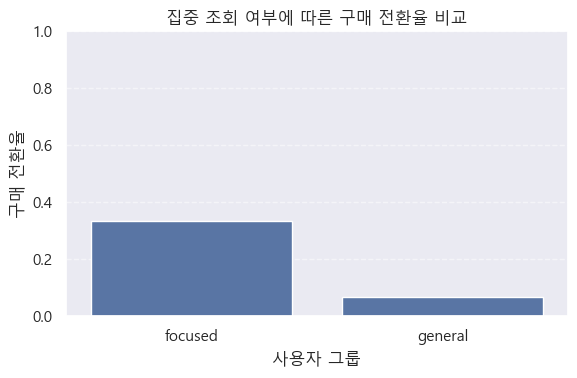

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 구매 전환율 계산용 데이터프레임 생성
group_summary = view_counts.groupby('group')['is_purchase'].agg(['sum', 'count']).reset_index()
group_summary['conversion_rate'] = group_summary['sum'] / group_summary['count']

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(data=group_summary, x='group', y='conversion_rate')
plt.title('집중 조회 여부에 따른 구매 전환율 비교')
plt.xlabel('사용자 그룹')
plt.ylabel('구매 전환율')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 3회 이상의 view 사용자 / 아닌 사용자 전환율 비교

📊 교차표:
 is_purchase      0.0     1.0
group                       
focused       374600  118894
general      1632938   95385
✅ 카이제곱 통계량: 151965.9618
✅ p-value: 0.000000


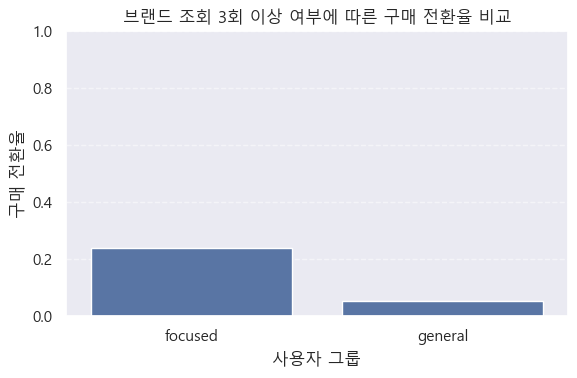

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 1. 브랜드-사용자별 view 수 계산
view_counts = df[df['event_type'] == 'view'].groupby(['brand', 'user_id']).size().reset_index(name='view_count')

# 2. 구매 여부 플래그 추가
purchase_flags = df[df['event_type'] == 'purchase'][['brand', 'user_id']].drop_duplicates()
purchase_flags['is_purchase'] = 1

# 3. 병합하여 구매 여부 추가
view_counts = view_counts.merge(purchase_flags, on=['brand', 'user_id'], how='left')
view_counts['is_purchase'] = view_counts['is_purchase'].fillna(0)

# 4. 그룹 나누기: 집중 뷰 (3회 이상) vs 일반 뷰 (3회 미만)
view_counts['group'] = view_counts['view_count'].apply(lambda x: 'focused' if x >= 3 else 'general')

# 5. 교차표 생성
contingency = pd.crosstab(view_counts['group'], view_counts['is_purchase'])

# 6. 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(contingency)

# 7. 결과 출력
print("📊 교차표:\n", contingency)
print(f"✅ 카이제곱 통계량: {chi2:.4f}")
print(f"✅ p-value: {p:.6f}")

# 8. 구매 전환율 계산
group_summary = view_counts.groupby('group')['is_purchase'].agg(['sum', 'count']).reset_index()
group_summary['conversion_rate'] = group_summary['sum'] / group_summary['count']

# 9. 시각화
plt.figure(figsize=(6, 4))
sns.barplot(data=group_summary, x='group', y='conversion_rate')
plt.title('브랜드 조회 3회 이상 여부에 따른 구매 전환율 비교')
plt.xlabel('사용자 그룹')
plt.ylabel('구매 전환율')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

True
- 특정 브랜드를 3회 이상 조회한 사용자가 그 브랜드 제품을 구매할 확률이 더 높다.
- 5회도 마찬가지

## H29_고가 제품을 조회한 사용자는 고가 제품을 구매하는지 여부

- 귀무가설(H0): 고가 제품을 조회한 사용자가 고가 제품을 구매할 확률은 그렇지 않은 사용자와 차이가 없다.
- 대립가설(H1): 고가 제품을 조회한 사용자가 고가 제품을 구매할 확률이 더 높다.

- 고가 제품 : 가격의 상위 20% 를 고가 제품으로 정의

In [25]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# 💡 가격 상위 20% 이상을 고가 제품으로 정의
price_threshold = df['price'].quantile(0.8)
high_price_products = df[df['price'] >= price_threshold]['product_id'].unique()

# 📌 고가 제품 조회한 사용자 목록
view_high_users = df[(df['event_type'] == 'view') & (df['product_id'].isin(high_price_products))]['user_id'].unique()

# 📌 고가 제품 구매한 사용자 목록
purchase_high_df = df[(df['event_type'] == 'purchase') & (df['product_id'].isin(high_price_products))]
purchase_high_users = purchase_high_df['user_id'].unique()

# 📌 전체 구매 사용자 목록
purchase_all_users = df[df['event_type'] == 'purchase']['user_id'].unique()

# ✅ 고가 제품 view 여부 기준으로 그룹 나누기
viewed_group = pd.Series(view_high_users)
not_viewed_group = pd.Series(list(set(purchase_all_users) - set(view_high_users)))

# 📌 교차표 작성
a = sum(viewed_group.isin(purchase_high_users))  # 고가 제품을 보고 → 고가 제품 구매한 사람 수
b = len(viewed_group) - a                        # 고가 제품을 보고 → 고가 제품 미구매한 사람 수
c = sum(not_viewed_group.isin(purchase_high_users))  # 고가 제품 안 보고 → 고가 제품 구매한 사람 수
d = len(not_viewed_group) - c                        # 고가 제품 안 보고 → 고가 제품 미구매한 사람 수

contingency = [[a, b], [c, d]]
chi2, p, dof, expected = chi2_contingency(contingency)

print("✅ 교차표:\n", pd.DataFrame(contingency, columns=['구매O', '구매X'], index=['고가뷰O', '고가뷰X']))
print(f"\n✅ 카이제곱 통계량: {chi2:.3f}, p-value: {p:.5f}")


✅ 교차표:
         구매O     구매X
고가뷰O  37734  519628
고가뷰X   6684   28418

✅ 카이제곱 통계량: 7168.799, p-value: 0.00000


|              | 고가 제품 구매 (O) | 고가 제품 구매 (X) | 총합      |
| ------------ | ------------ | ------------ | ------- |
| 고가 제품 조회(O)  | 37,734       | 519,628      | 557,362 |
| 고가 제품 미조회(X) | 6,684        | 28,418       | 35,102  |

- 고가 제품 조회 그룹: 약 6.8% (37,734 / 557,362)만 실제 고가 제품을 구매함
- 고가 제품 미조회 그룹: 약 19.0% (6,684 / 35,102)가 고가 제품을 구매함

→ 오히려 고가 제품을 조회하지 않은 사용자의 고가 제품 구매 전환율이 더 높게 나타났다.

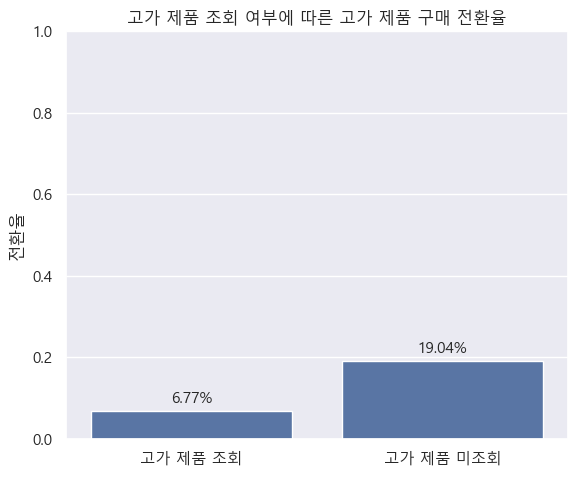

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 전환율 계산
conversion_rate_viewed = a / (a + b)
conversion_rate_not_viewed = c / (c + d)

conversion_df = pd.DataFrame({
    'group': ['고가 제품 조회', '고가 제품 미조회'],
    'conversion_rate': [conversion_rate_viewed, conversion_rate_not_viewed]
})

# 바플롯 시각화
plt.figure(figsize=(6, 5))
ax = sns.barplot(data=conversion_df, x='group', y='conversion_rate')
plt.title('고가 제품 조회 여부에 따른 고가 제품 구매 전환율')
plt.ylabel('전환율')
plt.xlabel('')
plt.ylim(0, 1)
plt.grid(True, axis='y')

# ✅ 바 위에 라벨 추가
for i, row in conversion_df.iterrows():
    ax.text(
        i, row['conversion_rate'] + 0.01,
        f"{row['conversion_rate']*100:.2f}%",
        ha='center', va='bottom', fontsize=11
    )

plt.tight_layout()
plt.show()

### 고가 제품을 3회 이상 조회한 사용자를 기준으로 구매 전환율 비교

In [28]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 고가 제품 기준 설정 (상위 20%)
price_threshold = df['price'].quantile(0.8)
high_price_products = df[df['price'] >= price_threshold]['product_id'].unique()

# 2. 고가 제품 조회 수 계산
high_view_counts = df[(df['event_type'] == 'view') & (df['product_id'].isin(high_price_products))]
user_high_view_counts = high_view_counts.groupby('user_id').size()

# 3. 그룹 나누기 (3회 이상 vs 미만)
group_3_or_more = user_high_view_counts[user_high_view_counts >= 3].index
group_less_than_3 = user_high_view_counts[user_high_view_counts < 3].index

# 4. 고가 제품 구매 여부 (user 기준)
purchase_high_users = df[(df['event_type'] == 'purchase') & (df['product_id'].isin(high_price_products))]['user_id'].unique()

# 5. 교차표 생성
a = sum(pd.Series(group_3_or_more).isin(purchase_high_users))   # 3회 이상 조회 & 구매
b = len(group_3_or_more) - a                                    # 3회 이상 조회 & 미구매
c = sum(pd.Series(group_less_than_3).isin(purchase_high_users)) # 3회 미만 조회 & 구매
d = len(group_less_than_3) - c                                  # 3회 미만 조회 & 미구매

contingency = [[a, b], [c, d]]
chi2, p, dof, expected = chi2_contingency(contingency)

print("✅ 교차표:\n", pd.DataFrame(contingency, columns=['구매O', '구매X'], index=['3회 이상 조회', '3회 미만 조회']))
print(f"\n✅ 카이제곱 통계량: {chi2:.3f}, p-value: {p:.5f}")

✅ 교차표:
             구매O     구매X
3회 이상 조회  26824  124860
3회 미만 조회  10910  394768

✅ 카이제곱 통계량: 39326.814, p-value: 0.00000


|              | 고가 제품 구매(O) | 고가 제품 미구매(X) | 전체       |
| ------------ | ----------- | ------------ | -------- |
| **3회 이상 조회** | 26,824명     | 124,860명     | 151,684명 |
| **3회 미만 조회** | 10,910명     | 394,768명     | 405,678명 |

- 3회 이상 조회자 전환율 = 26,824 / (26,824 + 124,860) ≈ 17.7%
- 3회 미만 조회자 전환율 = 10,910 / (10,910 + 394,768) ≈ 2.7%

→ 3회 이상 조회한 그룹의 고가 제품 구매 전환율이 훨씬 높음.

**고가 제품을 3회 이상 조회한 사용자는 그렇지 않은 사용자보다 고가 제품을 더 많이 구매함.**

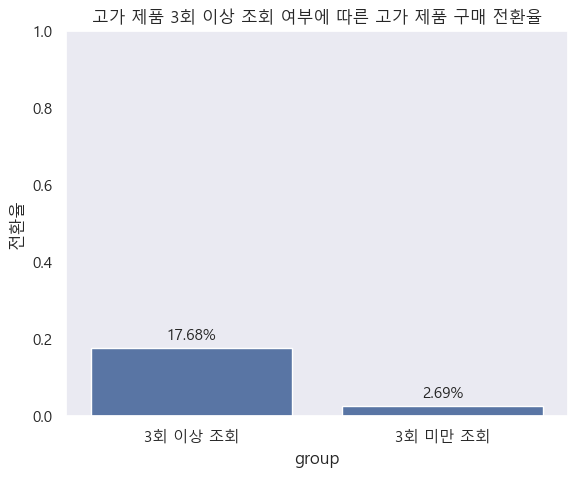

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 전환율 데이터프레임
conversion_df = pd.DataFrame({
    'group': ['3회 이상 조회', '3회 미만 조회'],
    'conversion_rate': [conversion_rate_3_or_more, conversion_rate_less_3]
})

# 시각화
plt.figure(figsize=(6, 5))
ax = sns.barplot(data=conversion_df, x='group', y='conversion_rate')

# 라벨(값) 붙이기
for i, row in conversion_df.iterrows():
    ax.text(
        i,                                  # x 위치
        row['conversion_rate'] + 0.01,      # y 위치 (막대보다 살짝 위)
        f"{row['conversion_rate']*100:.2f}%",  # 전환율(%)
        ha='center', va='bottom', fontsize=11
    )

plt.title('고가 제품 3회 이상 조회 여부에 따른 고가 제품 구매 전환율')
plt.ylabel('전환율')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## H30_기존 구매 평균 금액이 높은 사용자는 그 후에도 평균 금액이 다른 이들보다 높을 것이다.

In [30]:
import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# 1. 구매만 필터링
purchase_df = df[df['event_type'] == 'purchase'].copy()
purchase_df['event_time'] = pd.to_datetime(purchase_df['event_time'])
purchase_df = purchase_df.sort_values(by=['user_id', 'event_time'])

# 2. 구매 순서 부여
purchase_df['purchase_order'] = purchase_df.groupby('user_id').cumcount() + 1

# 3. 기존/이후 나누기 (예: 3건 기준)
initial_purchases = purchase_df[purchase_df['purchase_order'] <= 3]
later_purchases = purchase_df[purchase_df['purchase_order'] > 3]

# 4. 사용자별 기존 평균 구매 금액
initial_avg = initial_purchases.groupby('user_id')['price'].mean().reset_index()
initial_avg.columns = ['user_id', 'initial_avg_price']

# 5. 사용자 그룹 나누기 (중위값 기준)
median_price = initial_avg['initial_avg_price'].median()
initial_avg['group'] = initial_avg['initial_avg_price'] > median_price  # True: 상위 그룹

# 6. 이후 구매 금액 병합
later_avg = later_purchases.groupby('user_id')['price'].mean().reset_index()
later_avg.columns = ['user_id', 'later_avg_price']
merged = pd.merge(initial_avg, later_avg, on='user_id')

# 7. 그룹별 이후 평균 구매금 비교
group_high = merged[merged['group'] == True]['later_avg_price']
group_low = merged[merged['group'] == False]['later_avg_price']

# 8. 정규성 검사
print(shapiro(group_high))
print(shapiro(group_low))

# 9. 가설 검정 (정규성 여부 따라 다르게)
stat, p = mannwhitneyu(group_high, group_low, alternative='greater')  # 또는 ttest_ind
print(f"p-value: {p}")

ShapiroResult(statistic=np.float64(0.5094588281056949), pvalue=np.float64(5.160427088736066e-118))
ShapiroResult(statistic=np.float64(0.4054846074537155), pvalue=np.float64(2.9387671409207956e-135))
p-value: 0.0


C:\Users\Administrator\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21709.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Administrator\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32991.
  res = hypotest_fun_out(*samples, **kwds)


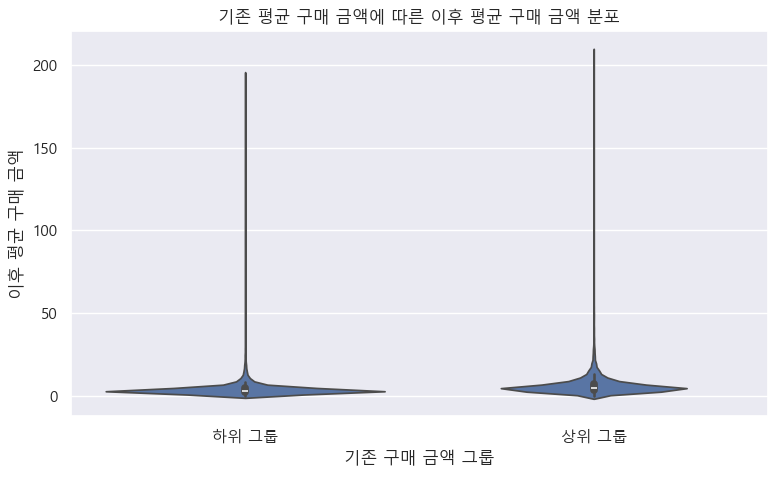

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화를 위한 DataFrame 구성
plot_df = merged.copy()
plot_df['group_label'] = plot_df['group'].map({True: '상위 그룹', False: '하위 그룹'})

plt.figure(figsize=(8, 5))
sns.violinplot(data=plot_df, x='group_label', y='later_avg_price', inner='box')
plt.title('기존 평균 구매 금액에 따른 이후 평균 구매 금액 분포')
plt.xlabel('기존 구매 금액 그룹')
plt.ylabel('이후 평균 구매 금액')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

- 대부분의 값이 낮은 구간에 몰려 있고 소수의 이상값이 분포를 왜곡하고 있어서 violin plot이나 box plot이 분포를 제대로 보여주지 못함
- 로그 변환하여 Boxplot으로 분석

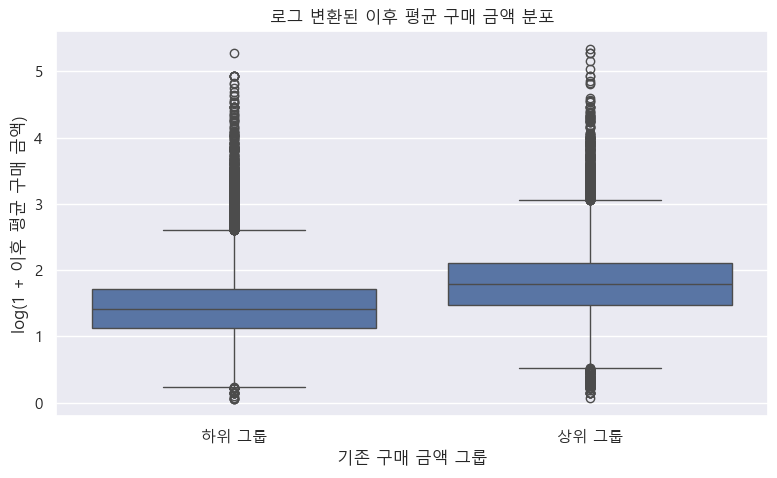

In [34]:
import numpy as np

# 로그 변환한 값 추가 (0 값 방지를 위해 log1p 사용)
plot_df['log_later_avg_price'] = np.log1p(plot_df['later_avg_price'])

plt.figure(figsize=(8, 5))
sns.boxplot(data=plot_df, x='group_label', y='log_later_avg_price')
plt.title('로그 변환된 이후 평균 구매 금액 분포')
plt.xlabel('기존 구매 금액 그룹')
plt.ylabel('log(1 + 이후 평균 구매 금액)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

- 중앙값(중간선):
    - 상위 그룹의 중앙값이 하위 그룹보다 높음
 
    → 상위 그룹은 이후 구매에서도 평균적으로 더 많은 금액을 지출하는 경향

- IQR (Interquartile Range, 박스 크기):
    - 두 그룹 모두 유사하지만, 상위 그룹이 약간 더 위쪽으로 치우침

    → 전반적으로 상위 그룹이 높은 구매 금액 구간에서 분포함

- 이상값 (outliers):

    - 양쪽 모두 이상값은 많지만, 상위 그룹 쪽 이상값이 더 고액에 집중됨

    → 고가 구매의 가능성 또한 상위 그룹에서 더 큼
**기존 평균 구매 금액이 높은 사용자일수록 이후 구매에서도 더 많은 금액을 쓰는 경향이 있다.**

### 기존 평균 구매 금액을 기준으로 상위 30%, 하위 30% 사용자 비교

In [35]:
# 사용자별 기존 평균 구매 금액
initial_avg = initial_purchases.groupby('user_id')['price'].mean().reset_index()
initial_avg.columns = ['user_id', 'initial_avg_price']

# 상위 30%, 하위 30% 기준 계산
high_threshold = initial_avg['initial_avg_price'].quantile(0.70)
low_threshold = initial_avg['initial_avg_price'].quantile(0.30)

# 조건에 따라 그룹 부여
initial_avg['group'] = initial_avg['initial_avg_price'].apply(
    lambda x: '상위 30%' if x > high_threshold else ('하위 30%' if x < low_threshold else '제외')
)

# 중간 40% 제외
filtered = initial_avg[initial_avg['group'] != '제외'].copy()

In [36]:
# 이후 구매 평균 금액
later_avg = later_purchases.groupby('user_id')['price'].mean().reset_index()
later_avg.columns = ['user_id', 'later_avg_price']

# 병합
merged = pd.merge(filtered, later_avg, on='user_id')

# 시각화용 라벨 정리
merged['group_label'] = merged['group']

In [38]:
from scipy.stats import mannwhitneyu

# 그룹별 분리
group_high = merged[merged['group'] == '상위 30%']['later_avg_price']
group_low = merged[merged['group'] == '하위 30%']['later_avg_price']

# Mann-Whitney U test (단측검정: 상위 그룹이 더 크다)
u_stat, p_value = mannwhitneyu(group_high, group_low, alternative='greater')

print(f"✅ Mann-Whitney U 통계량: {u_stat}")
print(f"✅ p-value: {p_value}")


✅ Mann-Whitney U 통계량: 170855084.0
✅ p-value: 0.0


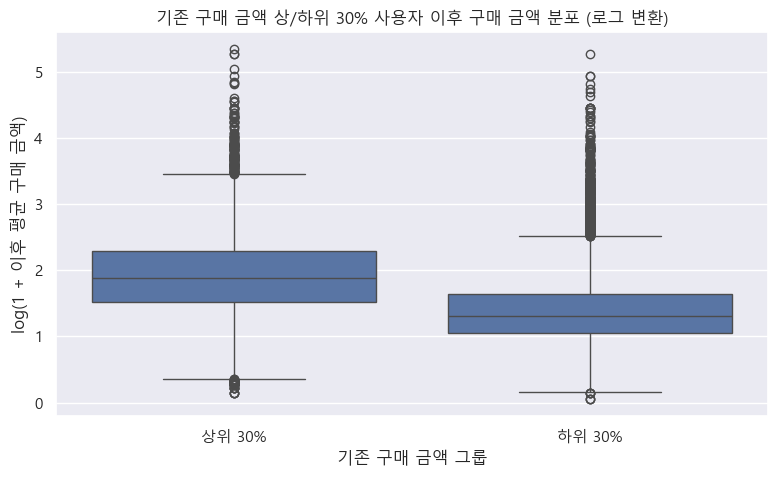

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

merged['log_later_avg_price'] = np.log1p(merged['later_avg_price'])

plt.figure(figsize=(8, 5))
sns.boxplot(data=merged, x='group_label', y='log_later_avg_price')
plt.title('기존 구매 금액 상/하위 30% 사용자 이후 구매 금액 분포 (로그 변환)')
plt.xlabel('기존 구매 금액 그룹')
plt.ylabel('log(1 + 이후 평균 구매 금액)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

- 상위 30% 유저가 이후에도 더 많이 씀 (중앙값 뚜렷하게 높음)
- 전체 금액 분포 역시 상위 그룹이 더 위에 있음
- 고액 이상값도 상위 그룹에 더 많이 몰려 있음

→ **원래 많이 쓰던 유저는 앞으로도 많이 씀**